<a href="https://colab.research.google.com/github/harun1yuksel/working/blob/master/anomaly_detection/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

# Catfish Sales Data

In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [4]:
url = "https://raw.githubusercontent.com/anhnguyendepocen/Time-Series-Analysis-1/master/catfish.csv"
catfish_sales = pd.read_csv(url, parse_dates=[0], index_col=0, date_parser=parser)

In [5]:
catfish_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 324 entries, 1986-01-01 to 2012-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Total   324 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


In [6]:
catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239
...,...
2012-08-01,14442
2012-09-01,13422
2012-10-01,13795


## Seasonal Decompose

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

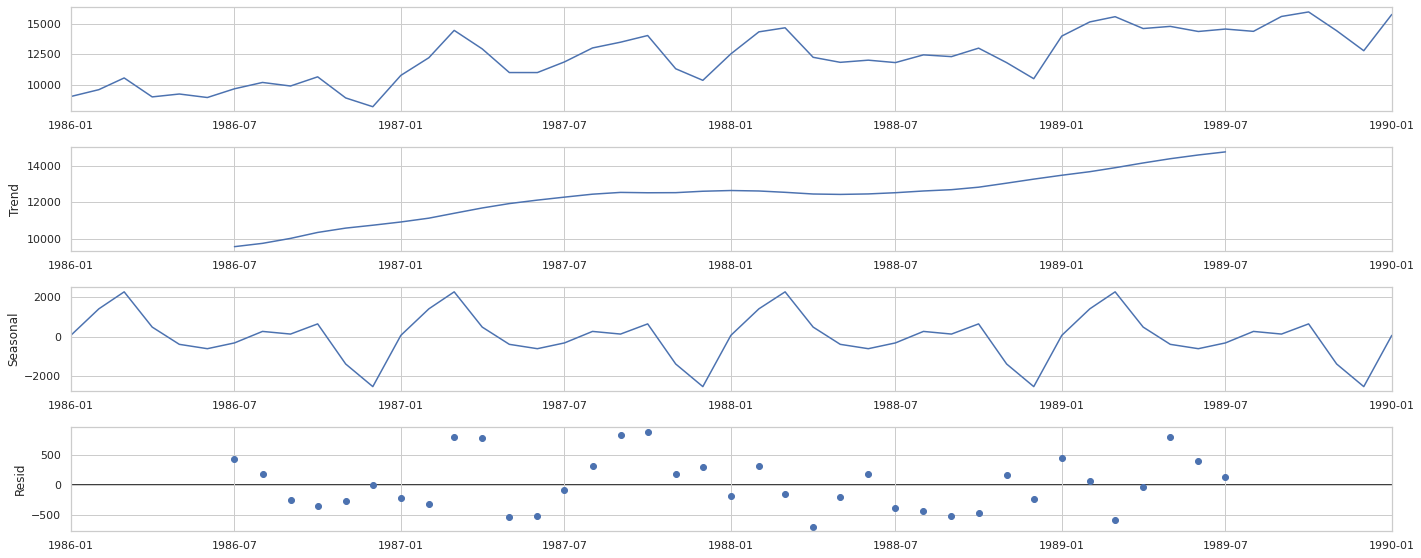

In [8]:
plt.rc('figure',figsize=(20,8))
plt.rc('font',size=15)

result = seasonal_decompose(catfish_sales.loc[:"1990-01-01"], model='additive')
fig = result.plot()

## Isolation forest

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

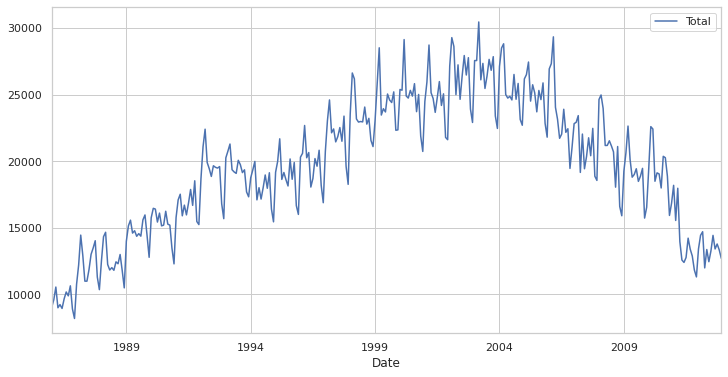

In [10]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
catfish_sales.plot()

In [11]:
url = "https://raw.githubusercontent.com/anhnguyendepocen/Time-Series-Analysis-1/master/catfish.csv"
catfish_sales = pd.read_csv(url, parse_dates=[0], index_col=0, date_parser=parser)

catfish_sales.loc["1998-12-1"]['Total'] = 10000
catfish_sales.loc["1990-12-1"]['Total'] = 23000
catfish_sales.loc["1993-3-1"]['Total'] = 30000
catfish_sales.loc["2003-3-1"]['Total'] = 35000

In [12]:
outliers_fraction = float(.01)

In [13]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(catfish_sales.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

In [14]:
model =  IsolationForest(contamination=outliers_fraction, n_estimators=500)
model.fit(data) 

IsolationForest(contamination=0.01, n_estimators=500)

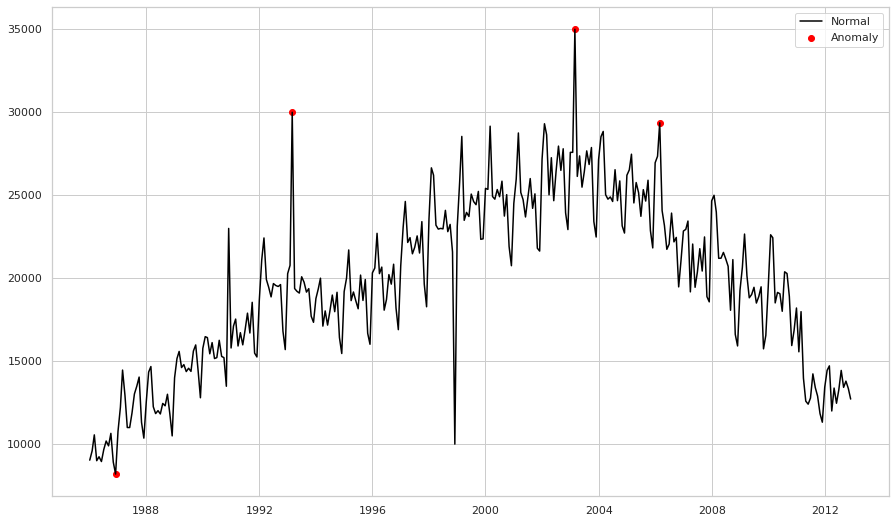

In [15]:
catfish_sales['anomaly'] = model.predict(data)

fig, ax = plt.subplots(figsize=(15,9))

a = catfish_sales.loc[catfish_sales['anomaly'] == -1, ['Total']] #anomaly

ax.plot(catfish_sales.index, catfish_sales['Total'], color='black', label = 'Normal')
ax.scatter(a.index,a['Total'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

## Forecasting with fbprophet

In [16]:
from fbprophet import Prophet

In [17]:
df = pd.read_csv("https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv")

In [18]:
df.tail(15)

,ds,y
2890,2016-01-06,8.352554
2891,2016-01-07,8.295798
2892,2016-01-08,8.290293
2893,2016-01-09,7.785721
2894,2016-01-10,8.281724
2895,2016-01-11,8.470730
2896,2016-01-12,8.135054
2897,2016-01-13,8.067149
2898,2016-01-14,8.023552
2899,2016-01-15,8.021913


In [19]:
df.shape

(2905, 2)

In [20]:
df.y.describe()

count    2905.000000
mean        8.138958
std         0.845957
min         5.262690
25%         7.514800
50%         7.997999
75%         8.580168
max        12.846747
Name: y, dtype: float64

In [21]:
df

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871


In [22]:
m = Prophet()
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
future = m.make_future_dataframe(periods=365, freq="D")
future.tail(15)

,ds
3255,2017-01-05
3256,2017-01-06
3257,2017-01-07
3258,2017-01-08
3259,2017-01-09
3260,2017-01-10
3261,2017-01-11
3262,2017-01-12
3263,2017-01-13
3264,2017-01-14


In [24]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.205422,7.538799,8.894079
3266,2017-01-16,8.515844,7.763476,9.286013
3267,2017-01-17,8.288459,7.527181,9.029245
3268,2017-01-18,8.114884,7.355564,8.830709
3269,2017-01-19,8.134712,7.394250,8.845990


In [25]:
forecast["on_off"] = np.random.randint(2, size=3270)

In [26]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,on_off
3265,2017-01-15,7.183070,7.538799,8.894079,6.840304,7.516319,1.022352,1.022352,1.022352,0.006120,0.006120,0.006120,0.047741,0.047741,0.047741,0.968492,0.968492,0.968492,0.0,0.0,0.0,8.205422,1
3266,2017-01-16,7.182036,7.763476,9.286013,6.836768,7.517630,1.333808,1.333808,1.333808,-0.009181,-0.009181,-0.009181,0.352504,0.352504,0.352504,0.990485,0.990485,0.990485,0.0,0.0,0.0,8.515844,0
3267,2017-01-17,7.181002,7.527181,9.029245,6.833653,7.518941,1.107456,1.107456,1.107456,-0.023701,-0.023701,-0.023701,0.119612,0.119612,0.119612,1.011545,1.011545,1.011545,0.0,0.0,0.0,8.288459,0
3268,2017-01-18,7.179969,7.355564,8.830709,6.830368,7.520252,0.934915,0.934915,0.934915,-0.030265,-0.030265,-0.030265,-0.066289,-0.066289,-0.066289,1.031470,1.031470,1.031470,0.0,0.0,0.0,8.114884,0
3269,2017-01-19,7.178935,7.394250,8.845990,6.828271,7.521563,0.955776,0.955776,0.955776,-0.022153,-0.022153,-0.022153,-0.072085,-0.072085,-0.072085,1.050015,1.050015,1.050015,0.0,0.0,0.0,8.134712,1


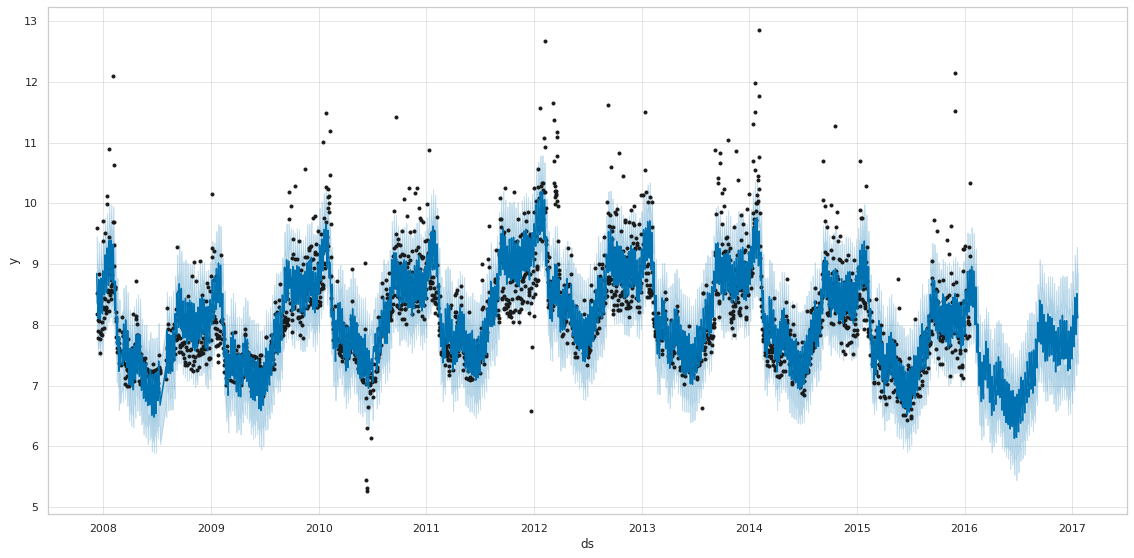

In [27]:
fig1 = m.plot(forecast, figsize=(16, 8))

In [28]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast, figsize=(1300, 700))

In [29]:
plot_components_plotly(m, forecast, figsize=(1300, 200))

In [30]:
test_size = 365

train = df[:-test_size]
test = df[-test_size:]

In [31]:
train.columns

Index(['ds', 'y'], dtype='object')

In [37]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def train_val(model, train, test):
    model = Prophet()
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(train)

    y_train_pred = model.predict(train)
    y_pred = model.predict(test)
    
    scores = {"train": {"R2" : r2_score(train["y"], y_train_pred["yhat"]),
    "mae" : mean_absolute_error(train["y"], y_train_pred["yhat"]),
    "mse" : mean_squared_error(train["y"], y_train_pred["yhat"]),                          
    "rmse" : np.sqrt(mean_squared_error(train["y"], y_train_pred["yhat"]))},
    
    "test": {"R2" : r2_score(test["y"], y_pred["yhat"]),
    "mae" : mean_absolute_error(test["y"], y_pred["yhat"]),
    "mse" : mean_squared_error(test["y"], y_pred["yhat"]),
    "rmse" : np.sqrt(mean_squared_error(test["y"], y_pred["yhat"]))}}
    
    return pd.DataFrame(scores)

In [38]:
train_val(model, train, test)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,train,test
R2,0.670145,0.434579
mae,0.343444,0.418025
mse,0.235606,0.295799
rmse,0.485392,0.543874


In [39]:
y_train_pred = m.predict(train)
y_pred = m.predict(test)

train_error = np.sqrt(mean_squared_error(train["y"], y_train_pred["yhat"]))
test_error = np.sqrt(mean_squared_error(test["y"], y_pred["yhat"]))

df_pred = pd.concat([test["y"].reset_index(drop=True), y_pred["yhat"].reset_index(drop=True)], axis=1)

import plotly.express as px

fig = px.line(df_pred, y=["y", "yhat"])

newnames = {"y": "Actual", "yhat": "Predicted"}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name], legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.show()

